<a href="https://colab.research.google.com/github/analystanand/Named_Entity_Recognition/blob/master/CONLL_2003_GRU_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
def readfile(filename):
  "get list of lines and tags"
  sentences,tags =[],[]
  with open(filename,"r") as file:
    temp_sent,temp_tag =[],[]
    for i in file.readlines():
      line = i.split() 
      if line:
          temp_sent.append(line[0])
          temp_tag.append(line[2])
      else:
          sentences.append(temp_sent)
          tags.append(temp_tag)
          temp_sent,temp_tag =[],[]
  return sentences,tags

In [0]:
def filter_sentences(lines,labels):
    modified_lines,modified_tags =[],[]
    for i,j in zip(lines,labels):
      if i[0]=="-DOCSTART-":
        continue
      l = [k.lower() for k in i]
      modified_lines.append(l)
      modified_tags.append(j)
    return modified_lines,modified_tags

In [0]:
def check_tags_length(lines,labels):
  for (i,j) in zip(lines,labels):
     assert len(i)==len(j)

In [0]:
train,train_label = readfile("/content/eng.train")
train,train_label = filter_sentences(train,train_label)
check_tags_length(train,train_label)
valid,valid_label = readfile("/content/eng.testa")
valid,valid_label = filter_sentences(valid,valid_label)
check_tags_length(valid,valid_label)
test,test_label = readfile("/content/eng.testb")
test,test_label = filter_sentences(test,test_label)
check_tags_length(test,test_label)

In [196]:
print("Length of Training Sentences:",len(train))
print("Length of Valid Sentences:",len(valid))
print("Length of Test Sentences:",len(test))

Length of Training Sentences: 14041
Length of Valid Sentences: 3250
Length of Test Sentences: 3453


In [197]:
print("sample training:",train[0],train_label[0])
print("sample validation:",valid[0],valid_label[0])
print("sample testing:",test[0],test_label[0])



sample training: ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.'] ['I-NP', 'I-VP', 'I-NP', 'I-NP', 'I-VP', 'I-VP', 'I-NP', 'I-NP', 'O']
sample validation: ['cricket', '-', 'leicestershire', 'take', 'over', 'at', 'top', 'after', 'innings', 'victory', '.'] ['I-NP', 'O', 'I-NP', 'I-NP', 'I-PP', 'I-NP', 'I-NP', 'I-NP', 'I-NP', 'I-NP', 'O']
sample testing: ['soccer', '-', 'japan', 'get', 'lucky', 'win', ',', 'china', 'in', 'surprise', 'defeat', '.'] ['I-NP', 'O', 'I-NP', 'I-VP', 'I-NP', 'I-NP', 'O', 'I-NP', 'I-PP', 'I-NP', 'I-NP', 'O']


In [0]:
def word_stats():
      wordfreq = {}
      word2index = {}
      index2word = {}
      vocab_length = 1

      for sent in train:
          for word in sent:
                if word in wordfreq.keys():
                    wordfreq[word]+=1
                else:
                    wordfreq[word]=1
                    vocab_length+=1  
      sorted_word_count = sorted(wordfreq.items(),key=lambda wordfreq:wordfreq[1],reverse=True)
      print("Vocabulary Length",vocab_length)

      filtered_vocab = 1
      word2index["UNK"]=1

      for (word,count) in sorted_word_count:
          if count > 1:
             filtered_vocab +=1
             word2index[word]=filtered_vocab
      print("Filtered Vocabulary",filtered_vocab)

      index2word = {v:k for k,v in word2index.items()}
      
      return word2index,index2word,vocab_length
      
      

In [0]:
def label_stats():
     label2index = {}
     index2label ={}
     labels_set = {k  for i in train_label for k in i }
     for index,label in enumerate(labels_set):
       label2index[label]=index
       index2label[index]=label
     n_labels = len(labels_set)
     print("No. of labels",n_labels)
     return label2index,index2label,n_labels

     

In [200]:
word2index,index2word,vocab_length = word_stats()

Vocabulary Length 21010
Filtered Vocabulary 10950


In [201]:
label2index,index2label,n_labels = label_stats()

No. of labels 17


In [0]:
def tensorfromlist(list_of_items,item2index):
    indexes = [item2index[k] if k in item2index.keys()  else item2index["UNK"] for k in list_of_items]
    return torch.tensor(indexes, dtype=torch.long)
    

In [0]:
# train_indexes = list(map(lambda x:tensorfromlist(x,word2index),train))
# train_label_indexes = list(map(lambda x:tensorfromlist(x,label2index),train_label))

# for i,k in zip(train_indexes,train_label_indexes):
#    for p in k.numpy():
#       print(type(p))

In [0]:
class RNN(nn.Module):
     def __init__(self,vocab_length,hidden_size,output_size):
       super(RNN, self).__init__()
       self.hidden_size= hidden_size
       self.embedding =  nn.Embedding(vocab_length,hidden_size)
       self.gru = nn.GRU(hidden_size,hidden_size)
       self.out = nn.Linear(hidden_size, output_size)
       self.softmax = nn.LogSoftmax(dim=1)
     def forward(self,input,hidden):
       embedded = self.embedding(input).view(1,1,-1)
       output = embedded
       output, hidden = self.gru(output,hidden)
       output = self.softmax(self.out(output[0]))
       return output,hidden
     def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)
         

In [0]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

In [0]:
def training(input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()
    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

In [0]:
import random

# Random item from a list
def randomChoice(l):
    return random.randint(0, l - 1)

# # Get a random category and random line from that category
def randomTrainingPair():
    choice = randomChoice(len(train))
    x = tensorfromlist(train[choice],word2index)
    y =tensorfromlist(train_label[choice],label2index)
    return x,y,choice

In [214]:
x,y,I = randomTrainingPair()
print(x.shape,y)

torch.Size([13]) tensor([12, 12, 14, 12, 14, 13, 12, 12, 14, 12, 14, 12, 12])


In [215]:
import math
import time

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


rnn = RNN(vocab_length, 128, n_labels)

n_iters = 10000
print_every =500
plot_every = 5
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    X,Y,index = randomTrainingPair()
    # print(index)
    # print(Y.shape)
    output, loss = training(X,Y)
    total_loss += loss
    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 36s (500 5%) 1.1002
1m 13s (1000 10%) 0.7448
1m 48s (1500 15%) 3.2552
2m 22s (2000 20%) 0.6252
2m 58s (2500 25%) 0.4524
3m 34s (3000 30%) 0.3339
4m 8s (3500 35%) 0.4362
4m 41s (4000 40%) 1.1015
5m 13s (4500 45%) 0.6207
5m 48s (5000 50%) 0.2468
6m 22s (5500 55%) 0.1304
6m 55s (6000 60%) 0.5493
7m 28s (6500 65%) 0.7759
8m 2s (7000 70%) 0.5542
8m 37s (7500 75%) 0.3885
9m 12s (8000 80%) 0.9463
9m 44s (8500 85%) 0.1146
10m 19s (9000 90%) 0.4632
10m 51s (9500 95%) 0.5706
11m 27s (10000 100%) 0.5108


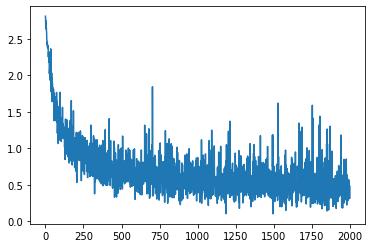

In [216]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

In [0]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    pred_tensor =  torch.zeros([line_tensor.size()[0], n_labels])
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        pred_tensor[i] = output 

    return pred_tensor

In [0]:
def predict(sample):
    x = tensorfromlist(sample,word2index)
    predictions_tag,prediction_index = [],torch.zeros(x.size()[0],dtype=torch.int8)
    with torch.no_grad():
      output_tensor = evaluate(x)      
    for i in range(x.shape[0]):
        category_index = output_tensor[i].max(0).indices.numpy().tolist()
        predictions_tag.append(index2label[category_index])
        prediction_index[i] =category_index
    return prediction_index


In [0]:
def accuracy(X,Y):
  correct =0
  total = 0
  for i,j in zip(X,Y):
      total += len(j)
      true_label = tensorfromlist(j,label2index)
      pred_label = predict(i)
      correct += (pred_label == true_label).sum().item()
  print('Accuracy of the network in predicting tags: %d %%' % (100 * correct / total))

In [220]:
accuracy(train,train_label)

Accuracy of the network in predicting tags: 85 %


In [221]:
accuracy(test,test_label)

Accuracy of the network in predicting tags: 86 %


In [222]:
accuracy(valid,valid_label)

Accuracy of the network in predicting tags: 85 %
